In [1]:
import math
import numpy as np
import pandas as pd
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

#from sklearn.externals.joblib import dump
#from sklearn.externals.joblib import load
#from sklearn.feature_selection import RFE

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# Create one random seed number for reproducible results
seedNum = 888

# Libraries for neural network
import tensorflow
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
outlier_flag = True      # Will threshold the outliers to outlier_max_value value
outlier_max_value = 25000
scale_flag = True
scale_cols=['n_tokens_title','average_token_length']

In [3]:
# Display all columns in pandas
pd.set_option('display.max_columns', None)

### Reading data

In [4]:
inputFile = '../data/output/OnlineNewsPopularity_featureEngg_BackEli.csv' #Kannan stiched this file
df = read_csv(inputFile)
df.columns = df.columns.str.replace(' ','')
print(df.shape)
df.head()

(7795, 107)


,n_tokens_title,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,is__Monday,is__Tuesday,is__Wednesday,is__Thursday,is__Friday,is_Weekend,polarity_title,subjectivity_content,LDA_T0,LDA_T3,LDA_T7,LDA_T8,NMF_T1,NMF_T2,NMF_T3,NMF_T4,NMF_T5,NMF_T6,NMF_T7,NMF_T8,NMF_T9,LSI_T0,LSI_T1,LSI_T2,LSI_T4,LSI_T5,LSI_T6,LSI_T7,LSI_T8,LDA_C0,LDA_C1,LDA_C6,LDA_C8,LDA_C9,NMF_C1,NMF_C2,NMF_C5,NMF_C6,NMF_C7,NMF_C9,LSI_C0,LSI_C4,LSI_C7,LSI_C8,LSI_C9,LDA_K0,LDA_K2,LDA_K5,LDA_K8,LDA_K9,NMF_K0,NMF_K1,NMF_K7,NMF_K8,NMF_K9,LSI_K0,LSI_K1,LSI_K3,LSI_K4,LSI_K6,LSI_K7,LSI_K9,keywords_pca_0,keywords_pca_2,keywords_pca_5,keywords_pca_6,keywords_pca_7,content_pca_1,content_pca_2,content_pca_3,content_pca_7,NER_list_pca_0,NER_list_pca_1,NER_list_pca_3,NER_list_pca_4,NER_list_pca_8,NER_most_common_pca_1,NER_most_common_pca_2,NER_most_common_pca_5,NER_most_common_pca_6,NER_most_common_pca_8,NER_GPE,NER_DATE,NER_ORG,NER_ORDINAL,NER_PRODUCT,NER_PERCENT,NER_LOC,NER_LANGUAGE,Id,url,shares
0,10,0.661355,1.0,0.787500,7,3,1,4.873563,7,0,0,0,0,0,1,1,0,0,0,0,0,0.000,0.390972,0.016667,0.016667,0.016667,0.016667,0.000000,0.000347,0.005389,0.000000,0.000000,0.031868,0.000839,0.0,0.006422,0.007722,0.008535,0.021316,0.020690,-0.006088,0.077717,-0.036213,-0.093264,0.010489,0.060015,0.073107,0.000248,0.039002,0.000000,0.0,0.000000,0.922646,0.000000,0.001072,9.623199,1.092459,-2.527858,-6.794291,-1.087015,0.025000,0.774985,0.025015,0.025000,0.025000,0.163539,0.00000,0.115788,0.000000,0.00564,1.337092,-0.312890,0.014332,-0.026212,0.147240,-0.247019,0.013849,13.136436,-0.715556,-0.919380,0.012948,-0.423773,20.801281,-8.014767,-13.831778,8.778829,71.769478,-0.305974,-2.477139,0.053204,-0.227759,0.527735,2.283769,0.212919,0.560122,0.234052,37,16,7,0,0,0,0,0,1,http://mashable.com/2014/09/01/americans-held-...,1100
1,7,0.370242,1.0,0.535038,74,3,50,4.554439,8,0,0,0,0,0,0,1,0,0,0,0,0,0.000,0.518788,0.016667,0.016667,0.016667,0.016667,0.210957,0.000000,0.000000,0.000000,0.000000,0.000000,0.273793,0.0,0.000000,0.201676,1.093307,-0.089313,-0.046514,-0.031308,0.133592,0.769232,-0.017455,0.775230,0.143104,0.000763,0.000763,0.000764,0.305919,0.0,0.000609,0.003877,0.037248,0.080931,4.020825,0.373879,-0.025431,-0.464149,0.066987,0.014291,0.014286,0.014286,0.014286,0.014287,0.000000,0.00000,0.000000,0.132696,0.00000,0.108038,0.157399,-0.085318,0.859231,-0.243774,-0.126836,-0.046871,6.786283,1.088876,0.458027,0.407789,0.523944,-12.000452,11.389012,-6.300879,3.648927,21.325382,-21.734667,-1.550308,1.541853,1.362484,9.357874,0.319776,-0.899578,0.791477,1.148880,1,3,15,0,0,0,0,0,2,http://mashable.com/2014/09/01/apple-visa-mast...,1100
2,7,0.524291,1.0,0.704918,3,3,1,5.003976,5,0,0,0,0,0,1,1,0,0,0,0,0,-0.075,0.348095,0.016667,0.183332,0.016667,0.016667,0.000000,0.002497,0.000653,0.001834,0.000000,0.000473,0.001090,0.0,0.009829,0.007068,0.002327,0.017026,0.010776,-0.005853,0.007454,0.003132,0.009621,0.000568,0.000568,0.000568,0.119522,0.137072,0.000000,0.0,0.082825,0.045050,0.086835,0.000000,2.446773,0.019481,1.210077,-0.780728,-0.065126,0.025000,0.524992,0.025007,0.275000,0.025000,0.000000,0.00048,0.152471,0.000000,0.00000,0.866041,-0.128185,0.121435,-0.041497,-0.551847,0.576938,-0.269132,0.567927,-0.608448,1.026721,0.301655,0.340355,22.819269,-3.552361,12.605568,-0.497396,63.302799,-10.992071,5.448328,1.981348,0.221779,9.445147,0.052364,0.472009,-0.200448,-0.185246,2,11,12,1,0,0,0,0,3,http://mashable.com/2014/09/01/aussie-football...,1000
3,10,0.536204,1.0,0.654867,17,1,1,4.998099,9,0,0,0,0,0,1,1,0,0,0,0,0,0.000,0.378684,0.219999,0.020000,0.020000,0.020000,0.000288,0.003077,0.006363,0.012337,0.011258,0.005025,0.000621,0.0,0.012646,0.028369,0.011266,0.033031,0.079579,-0.014036,0.014162,0.005381,-0.014938,0.236412,0.114992,0.000490,0.000490,0.000490,0.009113,0.0,0.001540,0.226946,0.1139

In [5]:
# Dropping useless attributes
df.drop('url', axis=1, inplace=True)
df.drop('Id', axis=1, inplace=True)

In [6]:
# variables for total columns, total input attributes, target column index and renaming target variable
totCol = len(df.columns)
totAttr = totCol-1
targetCol = totCol #last column
df.rename(columns={'shares': 'targetVar'}, inplace=True)

In [7]:
# Threshold the value > outlier_max_value to value outlier_max_value itself in column shares or targetVar
if outlier_flag:
    print(df[(df['targetVar'] == outlier_max_value)].shape)
    print(df[(df['targetVar'] > outlier_max_value)].shape)
    df['targetVar'] = df['targetVar'].clip(upper = outlier_max_value)
    print(df[(df['targetVar'] == outlier_max_value)].shape)
    print("shape is: ",df.shape)

(2, 105)
(106, 105)
(108, 105)
shape is:  (7795, 105)


In [8]:
#70:30 train test split
if targetCol == totCol :
    x_df = df.iloc[:,0:totAttr]
    y_df = df.iloc[:,totAttr]
else :
    x_df = df.iloc[:,1:totCol]
    y_df = df.iloc[:,0]

validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=validation_size, random_state=seedNum)
print("x_df.shape: {} y_df.shape: {}".format(x_df.shape, y_df.shape))
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_df.shape: (7795, 104) y_df.shape: (7795,)
x_train.shape: (5456, 104) y_train.shape: (5456,)
x_test.shape: (2339, 104) y_test.shape: (2339,)


In [9]:
# visualization configs
dispCol = 3
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to 16 and height to 12 (4:3 aspect ratio)
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
pyplot.rcParams["figure.figsize"] = fig_size

In [10]:
#kannan: This is decided from feature engineering / feature selection
lowAttributes=[]

In [11]:
# Removing the unselected attributes from the training and validation dataframes
#xy_train <- xy_train[, !(names(xy_train) %in% lowAttributes)]
#xy_test <- xy_test[, !(names(xy_test) %in% lowAttributes)]
xy_newdf = df.drop(lowAttributes, axis=1)

totCol = len(xy_newdf.columns)
totAttr = totCol-1
targetCol = totCol
#array = xy_newdf.values

if targetCol == totCol :
    #x_newdf = array[:,0:totAttr]
    #y_newdf = array[:,totAttr]
    x_newdf = xy_newdf.iloc[:,0:totAttr]
    y_newdf = xy_newdf.iloc[:,totAttr]

else :
    #x_newdf = array[:,1:totCol]
    #y_newdf = array[:,0]
    x_newdf = xy_newdf.iloc[:,1:totCol]
    y_newdf = xy_newdf.iloc[:,0]

validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_newdf, y_newdf, test_size=validation_size, random_state=seedNum)
print("x_newdf.shape: {} y_newdf.shape: {}".format(x_newdf.shape, y_newdf.shape))
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_newdf.shape: (7795, 104) y_newdf.shape: (7795,)
x_train.shape: (5456, 104) y_train.shape: (5456,)
x_test.shape: (2339, 104) y_test.shape: (2339,)


In [12]:
x_train.head()

,n_tokens_title,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,is__Monday,is__Tuesday,is__Wednesday,is__Thursday,is__Friday,is_Weekend,polarity_title,subjectivity_content,LDA_T0,LDA_T3,LDA_T7,LDA_T8,NMF_T1,NMF_T2,NMF_T3,NMF_T4,NMF_T5,NMF_T6,NMF_T7,NMF_T8,NMF_T9,LSI_T0,LSI_T1,LSI_T2,LSI_T4,LSI_T5,LSI_T6,LSI_T7,LSI_T8,LDA_C0,LDA_C1,LDA_C6,LDA_C8,LDA_C9,NMF_C1,NMF_C2,NMF_C5,NMF_C6,NMF_C7,NMF_C9,LSI_C0,LSI_C4,LSI_C7,LSI_C8,LSI_C9,LDA_K0,LDA_K2,LDA_K5,LDA_K8,LDA_K9,NMF_K0,NMF_K1,NMF_K7,NMF_K8,NMF_K9,LSI_K0,LSI_K1,LSI_K3,LSI_K4,LSI_K6,LSI_K7,LSI_K9,keywords_pca_0,keywords_pca_2,keywords_pca_5,keywords_pca_6,keywords_pca_7,content_pca_1,content_pca_2,content_pca_3,content_pca_7,NER_list_pca_0,NER_list_pca_1,NER_list_pca_3,NER_list_pca_4,NER_list_pca_8,NER_most_common_pca_1,NER_most_common_pca_2,NER_most_common_pca_5,NER_most_common_pca_6,NER_most_common_pca_8,NER_GPE,NER_DATE,NER_ORG,NER_ORDINAL,NER_PRODUCT,NER_PERCENT,NER_LOC,NER_LANGUAGE
5616,12,0.572917,1.0,0.724138,5,2,1,4.303030,6,0,0,1,0,0,0,0,0,0,0,1,0,0.000000,0.461524,0.012500,0.012500,0.262501,0.012500,0.000000,0.485745,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.046935,0.247683,0.065998,1.950709,-0.239969,-0.029557,-0.111046,-0.047286,-0.081700,0.076663,0.001450,0.027686,0.083131,0.306616,0.005582,0.012801,0.045012,0.000000,0.054749,0.015779,1.433652,-0.381788,0.404786,0.471106,-0.405451,0.014286,0.014286,0.014286,0.322990,0.014287,0.000000,0.237873,0.000000,0.000409,0.0,0.415018,1.902896,0.315155,-0.093395,0.148457,0.108515,-0.367599,-5.959097,1.683136,0.011106,0.879314,-0.486422,3.952612,1.028442,9.393019,-4.970053,34.898693,-2.668137,0.123655,0.646328,1.277369,9.603681,0.196828,0.391160,-1.597154,0.640023,0,3,2,1,1,0,0,0
6870,10,0.481178,1.0,0.628205,28,14,15,4.775157,9,0,0,0,0,0,0,0,0,0,1,0,0,-0.155556,0.312681,0.299999,0.014286,0.157143,0.300002,0.000000,0.000000,0.005282,0.000000,0.000000,0.000000,0.0,0.624836,0.000000,0.080466,0.061472,0.101351,0.235617,-0.161890,0.958502,-0.490399,1.044917,0.234999,0.449896,0.075641,0.000510,0.000510,0.000000,0.006909,0.000000,0.257970,0.006044,0.430436,6.180570,-2.058178,-2.633270,-1.886967,-4.531420,0.020000,0.020002,0.619997,0.020000,0.020000,0.162353,0.000000,0.115559,0.016281,0.0,1.335836,-0.306786,0.006437,-0.018187,0.143015,-0.250917,-0.026151,3.925468,-1.069448,0.090239,0.066486,0.224716,-4.035719,23.265581,-19.935139,-1.736734,12.188890,-23.260721,-0.508598,0.542870,0.213079,10.047768,0.535428,-1.165734,0.556392,-0.598910,6,5,17,1,1,0,1,0
6352,9,0.726496,1.0,0.866667,4,3,1,4.783333,10,0,0,1,0,0,0,0,0,0,1,0,0,0.600000,0.645195,0.033333,0.366668,0.366666,0.033333,0.001749,0.002203,0.000000,0.000000,0.001350,0.006486,0.0,0.008057,0.006945,0.020017,0.015278,0.016633,0.011830,0.007092,0.035408,-0.036300,0.010229,0.530777,0.278907,0.000699,0.000699,0.149513,0.029134,0.000000,0.000000,0.005481,0.067765,0.146939,2.922663,-0.761132,0.092784,0.002288,-1.682952,0.033338,0.033333,0.033333,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.0,0.026843,0.043422,-0.015214,0.905675,-0.085464,-0.053600,-0.008575,-6.478974,-0.834234,0.627788,0.131379,-0.254197,-10.712171,11.687694,-7.684834,8.041782,21.526173,-20.824898,0.718214,1.722503,-1.417109,9.150861,1.649384,0.971018,-1.262274,0.474450,0,3,15,0,0,0,0,0
2223,11,0.360377,1.0,0.522766,3,3,9,4.079777,6,0,1,0,0,0,0,0,0,0,0,0,1,0.800000,0.515092,0.033333,0.033333,0.033333,0.033333,0.000000,0.002417,0.000000,0.000970,0.000483,0.000000,0.0,0.000000,0.010060,0.007053,0.001388,0.017393,0.011207,-0.001434,0.002002,-0.004677,0.013319,0.005481,0.004703,0.000143,0.901791,0.003326,0.000000,0.000000,1.619350,0.020473,0.003981,0.000000,11.806714,-6.904986,-1.229484,-1.904741,-7.920577,0.016667,0.204877,0.016680,0.349998,0.016670,0.002004,0.000000,0.002563,0.002532,0.0,0.14

In [13]:
x_test.head()

,n_tokens_title,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,is__Monday,is__Tuesday,is__Wednesday,is__Thursday,is__Friday,is_Weekend,polarity_title,subjectivity_content,LDA_T0,LDA_T3,LDA_T7,LDA_T8,NMF_T1,NMF_T2,NMF_T3,NMF_T4,NMF_T5,NMF_T6,NMF_T7,NMF_T8,NMF_T9,LSI_T0,LSI_T1,LSI_T2,LSI_T4,LSI_T5,LSI_T6,LSI_T7,LSI_T8,LDA_C0,LDA_C1,LDA_C6,LDA_C8,LDA_C9,NMF_C1,NMF_C2,NMF_C5,NMF_C6,NMF_C7,NMF_C9,LSI_C0,LSI_C4,LSI_C7,LSI_C8,LSI_C9,LDA_K0,LDA_K2,LDA_K5,LDA_K8,LDA_K9,NMF_K0,NMF_K1,NMF_K7,NMF_K8,NMF_K9,LSI_K0,LSI_K1,LSI_K3,LSI_K4,LSI_K6,LSI_K7,LSI_K9,keywords_pca_0,keywords_pca_2,keywords_pca_5,keywords_pca_6,keywords_pca_7,content_pca_1,content_pca_2,content_pca_3,content_pca_7,NER_list_pca_0,NER_list_pca_1,NER_list_pca_3,NER_list_pca_4,NER_list_pca_8,NER_most_common_pca_1,NER_most_common_pca_2,NER_most_common_pca_5,NER_most_common_pca_6,NER_most_common_pca_8,NER_GPE,NER_DATE,NER_ORG,NER_ORDINAL,NER_PRODUCT,NER_PERCENT,NER_LOC,NER_LANGUAGE
4410,10,0.000000,0.0,0.000000,0,0,1,0.000000,7,0,0,0,0,0,0,0,0,1,0,0,0,0.000000,0.444156,0.025000,0.025000,0.025000,0.025000,0.000000,0.000000,0.000113,0.000050,0.000218,0.000110,0.000073,0.000387,0.001554,0.000820,0.000963,0.001380,0.002762,0.000038,0.003085,-0.000803,0.001662,0.000962,0.251981,0.000962,0.000962,0.206360,0.000000,0.000288,0.040060,0.020023,0.000000,0.000000,2.393879,0.771329,-0.379362,-0.385504,0.061507,0.020000,0.020000,0.020000,0.020000,0.020000,0.000000,0.152281,0.000651,0.000000,0.000000,0.243160,1.078529,-0.493418,-0.068980,0.017577,0.007664,0.006398,2.371106,-1.506181,-1.243707,-0.477734,0.871323,12.256122,2.255146,0.642883,9.780233,25.099144,18.336580,-1.330211,-0.120420,0.091908,12.133107,-0.721219,0.634915,0.272695,-1.673541,10,2,4,0,0,0,0,0
7387,9,0.584967,1.0,0.793939,1,0,1,4.270968,4,0,0,0,1,0,0,0,0,0,0,1,0,1.000000,0.579851,0.025000,0.025000,0.025000,0.025000,0.024619,0.000000,0.000000,0.001523,0.000000,0.001876,0.010819,0.005753,0.050902,0.042916,0.135102,0.021036,0.033104,-0.025759,0.082142,0.014297,0.189568,0.731816,0.196733,0.000208,0.020232,0.022636,0.228968,0.000000,0.014824,0.000000,0.248456,1.242514,12.578507,-3.448331,-1.902134,4.876117,-11.572372,0.012500,0.142406,0.012500,0.012500,0.186105,0.000000,0.000000,0.000000,0.269612,0.000000,0.131337,0.174242,-0.075162,-0.100717,-0.018543,-0.017034,-0.077612,-4.732383,0.113750,-0.341706,-0.696985,-0.067413,-31.404490,29.189899,6.972684,-11.259977,38.012901,-25.951107,-1.071599,0.956732,-1.577117,-4.320701,-0.919229,-1.257425,-1.092131,0.440065,1,7,23,0,0,0,0,0
4532,10,0.575419,1.0,0.727273,27,4,1,4.661804,8,0,1,0,0,0,0,0,0,0,1,0,0,0.500000,0.269378,0.033333,0.033333,0.033333,0.033333,0.000896,0.000204,0.005998,0.000000,0.000000,0.019949,0.000000,0.015787,0.005530,0.026545,0.023149,0.018780,0.005119,-0.006720,0.100118,-0.076533,-0.086628,0.021588,0.645078,0.099516,0.000763,0.105695,0.000000,0.000000,0.029003,0.048389,0.049002,0.010424,2.270466,-0.327251,0.263666,-0.043650,-0.256960,0.012500,0.012502,0.387503,0.137499,0.012500,0.163014,0.000000,0.119872,0.003485,0.000000,1.371573,-0.295891,-0.008211,-0.014805,0.198768,-0.158729,-0.019883,5.246181,0.365328,-0.444127,0.291205,-0.364850,5.190913,2.919482,-8.796712,9.457913,42.599194,-8.193209,-2.434064,-1.251123,-1.449153,7.784821,0.336521,-1.302619,0.215109,-0.149268,7,12,3,0,0,2,0,0
5493,11,0.514184,1.0,0.655271,11,1,1,4.474490,5,0,0,0,0,0,0,0,0,0,1,0,0,0.000000,0.461640,0.275001,0.025006,0.025000,0.275000,0.000000,0.001308,0.000000,0.001283,0.001637,0.003349,0.000000,0.002510,0.014153,0.021984,0.002253,0.012847,0.030526,-0.004398,0.023583,-0.011977,0.009277,0.000794,0.116554,0.000794,0.015153,0.078036,0.000000,0.000000,0.020576,0.277184,0.000000,0.000000,3.304932,-0.167015,-1.209501,-2.184963,0.238652,0.020000,0.020000,0.020000,0.595890,0.020001,0.00

In [14]:
#scale_cols=['n_tokens_title','average_token_length']

In [15]:
if scale_flag:
    
    def scale_trn(df, columns):
        for col in columns:
            df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0) 
        return df

    def scale_tst(df, df_trn_tmp, columns):
        for col in columns:
            df[col] = (df[col] - df_trn_tmp[col].mean())/df_trn_tmp[col].std(ddof=0) 
        return df
    
    x_train = scale_trn(x_train.copy(), scale_cols)
    x_test  = scale_tst(x_test.copy(), x_train.copy(), scale_cols)

In [16]:
x_train.head()

,n_tokens_title,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,is__Monday,is__Tuesday,is__Wednesday,is__Thursday,is__Friday,is_Weekend,polarity_title,subjectivity_content,LDA_T0,LDA_T3,LDA_T7,LDA_T8,NMF_T1,NMF_T2,NMF_T3,NMF_T4,NMF_T5,NMF_T6,NMF_T7,NMF_T8,NMF_T9,LSI_T0,LSI_T1,LSI_T2,LSI_T4,LSI_T5,LSI_T6,LSI_T7,LSI_T8,LDA_C0,LDA_C1,LDA_C6,LDA_C8,LDA_C9,NMF_C1,NMF_C2,NMF_C5,NMF_C6,NMF_C7,NMF_C9,LSI_C0,LSI_C4,LSI_C7,LSI_C8,LSI_C9,LDA_K0,LDA_K2,LDA_K5,LDA_K8,LDA_K9,NMF_K0,NMF_K1,NMF_K7,NMF_K8,NMF_K9,LSI_K0,LSI_K1,LSI_K3,LSI_K4,LSI_K6,LSI_K7,LSI_K9,keywords_pca_0,keywords_pca_2,keywords_pca_5,keywords_pca_6,keywords_pca_7,content_pca_1,content_pca_2,content_pca_3,content_pca_7,NER_list_pca_0,NER_list_pca_1,NER_list_pca_3,NER_list_pca_4,NER_list_pca_8,NER_most_common_pca_1,NER_most_common_pca_2,NER_most_common_pca_5,NER_most_common_pca_6,NER_most_common_pca_8,NER_GPE,NER_DATE,NER_ORG,NER_ORDINAL,NER_PRODUCT,NER_PERCENT,NER_LOC,NER_LANGUAGE
5616,0.411743,0.572917,1.0,0.724138,5,2,1,0.025244,6,0,0,1,0,0,0,0,0,0,0,1,0,0.000000,0.461524,0.012500,0.012500,0.262501,0.012500,0.000000,0.485745,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.046935,0.247683,0.065998,1.950709,-0.239969,-0.029557,-0.111046,-0.047286,-0.081700,0.076663,0.001450,0.027686,0.083131,0.306616,0.005582,0.012801,0.045012,0.000000,0.054749,0.015779,1.433652,-0.381788,0.404786,0.471106,-0.405451,0.014286,0.014286,0.014286,0.322990,0.014287,0.000000,0.237873,0.000000,0.000409,0.0,0.415018,1.902896,0.315155,-0.093395,0.148457,0.108515,-0.367599,-5.959097,1.683136,0.011106,0.879314,-0.486422,3.952612,1.028442,9.393019,-4.970053,34.898693,-2.668137,0.123655,0.646328,1.277369,9.603681,0.196828,0.391160,-1.597154,0.640023,0,3,2,1,1,0,0,0
6870,-0.512540,0.481178,1.0,0.628205,28,14,15,0.367743,9,0,0,0,0,0,0,0,0,0,1,0,0,-0.155556,0.312681,0.299999,0.014286,0.157143,0.300002,0.000000,0.000000,0.005282,0.000000,0.000000,0.000000,0.0,0.624836,0.000000,0.080466,0.061472,0.101351,0.235617,-0.161890,0.958502,-0.490399,1.044917,0.234999,0.449896,0.075641,0.000510,0.000510,0.000000,0.006909,0.000000,0.257970,0.006044,0.430436,6.180570,-2.058178,-2.633270,-1.886967,-4.531420,0.020000,0.020002,0.619997,0.020000,0.020000,0.162353,0.000000,0.115559,0.016281,0.0,1.335836,-0.306786,0.006437,-0.018187,0.143015,-0.250917,-0.026151,3.925468,-1.069448,0.090239,0.066486,0.224716,-4.035719,23.265581,-19.935139,-1.736734,12.188890,-23.260721,-0.508598,0.542870,0.213079,10.047768,0.535428,-1.165734,0.556392,-0.598910,6,5,17,1,1,0,1,0
6352,-0.974681,0.726496,1.0,0.866667,4,3,1,0.373675,10,0,0,1,0,0,0,0,0,0,1,0,0,0.600000,0.645195,0.033333,0.366668,0.366666,0.033333,0.001749,0.002203,0.000000,0.000000,0.001350,0.006486,0.0,0.008057,0.006945,0.020017,0.015278,0.016633,0.011830,0.007092,0.035408,-0.036300,0.010229,0.530777,0.278907,0.000699,0.000699,0.149513,0.029134,0.000000,0.000000,0.005481,0.067765,0.146939,2.922663,-0.761132,0.092784,0.002288,-1.682952,0.033338,0.033333,0.033333,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.0,0.026843,0.043422,-0.015214,0.905675,-0.085464,-0.053600,-0.008575,-6.478974,-0.834234,0.627788,0.131379,-0.254197,-10.712171,11.687694,-7.684834,8.041782,21.526173,-20.824898,0.718214,1.722503,-1.417109,9.150861,1.649384,0.971018,-1.262274,0.474450,0,3,15,0,0,0,0,0
2223,-0.050398,0.360377,1.0,0.522766,3,3,9,-0.136712,6,0,1,0,0,0,0,0,0,0,0,0,1,0.800000,0.515092,0.033333,0.033333,0.033333,0.033333,0.000000,0.002417,0.000000,0.000970,0.000483,0.000000,0.0,0.000000,0.010060,0.007053,0.001388,0.017393,0.011207,-0.001434,0.002002,-0.004677,0.013319,0.005481,0.004703,0.000143,0.901791,0.003326,0.000000,0.000000,1.619350,0.020473,0.003981,0.000000,11.806714,-6.904986,-1.229484,-1.904741,-7.920577,0.016667,0.204877,0.016680,0.349998,0.016670,0.002004,0.0000

In [17]:
if isinstance(x_train, pd.DataFrame):
    x_train = x_train.values
    y_train = y_train.values
    print("train data change from DataFrame to Numpy ")
    
if isinstance(x_test, pd.DataFrame):
    x_test = x_test.values
    y_test = y_test.values
    print("test data change from DataFrame to Numpy ")

train data change from DataFrame to Numpy 
test data change from DataFrame to Numpy 


## Traditional ML Models Evaluation

In [18]:
# Comparing various types of regression # K-fold cross validation
num_folds = 10
scoring = 'neg_mean_squared_error'
#Other scoring options: https://scikit-learn.org/stable/modules/model_evaluation.html
models = []

# LINEAR ALGORITHMS
# -----------------
# Linear Regression
models.append(('LR', LinearRegression()))
# Ridge Regression
models.append(('RR', Ridge(random_state=seedNum)))
# Lasso Regression
models.append(('LASSO', Lasso(random_state=seedNum)))
# Elastic Net
models.append(('EN', ElasticNet(random_state=seedNum)))

# NON-LINEAR ALGORITHMS
# ---------------------
# Classification and Regression Trees
models.append(('CART', DecisionTreeRegressor(random_state=seedNum)))
# K Nearest Neighbor
models.append(('KNN', KNeighborsRegressor()))
# Suppor Vector machine
models.append(('SVM', SVR()))

# ENSEMBLE ALGORITHMS
# -------------------
# Extra Trees
models.append(('ETree', ExtraTreesRegressor(random_state=seedNum)))
# Random Forest
models.append(('RF', RandomForestRegressor(random_state=seedNum)))
# Stochastic Gradient Boosting
models.append(('GBM', GradientBoostingRegressor(random_state=seedNum)))
# Adaptive Boosting
models.append(('ABM', AdaBoostRegressor(random_state=seedNum)))

results = []
names = []
metrics1= [] #RMSE_Training
metrics2= [] #RMSE_Testing

## Adding DL Model

In [19]:
def baseline_model(init_mode='uniform', neurons=5, learn_rate=0.001, momentum=0.2, act_function='relu'):
        
    model = Sequential()
    
    model.add(BatchNormalization())
    model.add(Dense(neurons, input_dim=17, kernel_initializer=init_mode, activation=act_function))
    model.add(Dense(6,  kernel_initializer=init_mode, activation=act_function))
    model.add(Dense(1,  kernel_initializer=init_mode))
    
    optimizer = tensorflow.keras.optimizers.RMSprop(lr=learn_rate, momentum=momentum)
    model.compile(loss='mean_squared_error', optimizer=optimizer, )
    
    return model

estimator = KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=10, verbose=0)

In [20]:
models.append(('DL', estimator))

## Training

In [21]:
for name, model in models:
    startTimeModule = datetime.now()
    kfold = KFold(n_splits=num_folds, random_state=seedNum)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    rmse=math.sqrt(abs(cv_results.mean()))
    metrics1.append(rmse)
    print("\n%s: rmse:%f" % (name, rmse))
    print ('Model training time:',(datetime.now() - startTimeModule))


LR: rmse:3807.832668
Model training time: 0:00:00.387924

RR: rmse:3809.196454
Model training time: 0:00:00.171573

LASSO: rmse:3807.913111
Model training time: 0:00:01.712060

EN: rmse:3852.969335
Model training time: 0:00:00.475698

CART: rmse:5582.343310
Model training time: 0:00:09.689816

KNN: rmse:4225.248226
Model training time: 0:00:04.133752

SVM: rmse:4108.583522
Model training time: 0:00:59.816496

ETree: rmse:3974.246239
Model training time: 0:02:08.220236

RF: rmse:4014.316570
Model training time: 0:08:21.273611

GBM: rmse:3914.693374
Model training time: 0:01:35.757972

ABM: rmse:4655.787626
Model training time: 0:00:12.966936
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

DL: rmse:3827.793600
Model training time: 0:04:44.903927


## Testing

In [22]:
for name, model in models:
    model.fit(x_train, y_train)
    predictions=model.predict(x_test)
    rmse=math.sqrt(mean_squared_error(y_test, predictions))
    metrics2.append(rmse)
    print("\n%s: rmse:%f" % (name, rmse))


LR: rmse:5475.242080

RR: rmse:5177.803767

LASSO: rmse:4793.708670

EN: rmse:4094.557359

CART: rmse:7612.700338

KNN: rmse:4435.782191

SVM: rmse:4352.921340

ETree: rmse:4791.980330

RF: rmse:5541.896285

GBM: rmse:4964.754454

ABM: rmse:6550.431482

DL: rmse:4047.290754


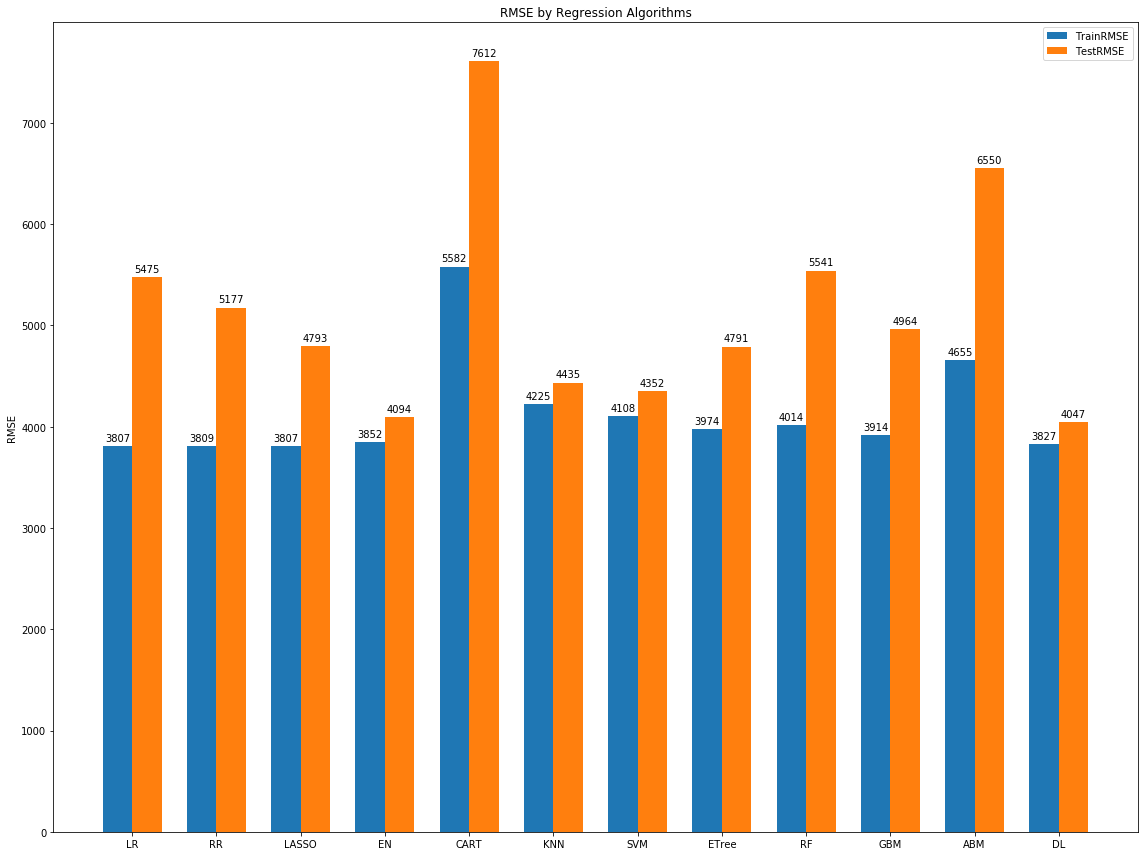

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = names

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

metrics1=[math.floor(item) for item in metrics1]
metrics2=[math.floor(item) for item in metrics2]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, metrics1, width, label='TrainRMSE')
rects2 = ax.bar(x + width/2, metrics2, width, label='TestRMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Regression Algorithms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [24]:
# Tuning algorithm #1 - ElasticNet
paramGrid1 = dict(alpha=np.array([1,2,3]),l1_ratio=np.array([0.1,0.5,0.8,1]),max_iter=np.array([500,1000,5000]))
model1 = ElasticNet(random_state=seedNum,normalize=False)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(x_train, y_train)

print("Best: %f using %s" % (math.sqrt(abs(grid_result1.best_score_)), grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('EN')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    #print("%f (%f) with: %r" % (mean, stdev, param))
    print("%f with: %r" % (math.sqrt(abs(mean)), param))


Best: 3805.881825 using {'alpha': 3, 'l1_ratio': 1.0, 'max_iter': 500}
3858.768781 with: {'alpha': 1, 'l1_ratio': 0.1, 'max_iter': 500}
3858.768781 with: {'alpha': 1, 'l1_ratio': 0.1, 'max_iter': 1000}
3858.768781 with: {'alpha': 1, 'l1_ratio': 0.1, 'max_iter': 5000}
3852.969335 with: {'alpha': 1, 'l1_ratio': 0.5, 'max_iter': 500}
3852.969335 with: {'alpha': 1, 'l1_ratio': 0.5, 'max_iter': 1000}
3852.969335 with: {'alpha': 1, 'l1_ratio': 0.5, 'max_iter': 5000}
3842.901087 with: {'alpha': 1, 'l1_ratio': 0.8, 'max_iter': 500}
3842.901087 with: {'alpha': 1, 'l1_ratio': 0.8, 'max_iter': 1000}
3842.901087 with: {'alpha': 1, 'l1_ratio': 0.8, 'max_iter': 5000}
3807.913111 with: {'alpha': 1, 'l1_ratio': 1.0, 'max_iter': 500}
3807.913111 with: {'alpha': 1, 'l1_ratio': 1.0, 'max_iter': 1000}
3807.913111 with: {'alpha': 1, 'l1_ratio': 1.0, 'max_iter': 5000}
3865.322851 with: {'alpha': 2, 'l1_ratio': 0.1, 'max_iter': 500}
3865.322851 with: {'alpha': 2, 'l1_ratio': 0.1, 'max_iter': 1000}
3865.32285

In [28]:
"""
# Tuning algorithm #2 - Support Vector Machine
paramGrid2 = dict(C=np.array([0.1,1,10]),epsilon=np.array([0.01,0.1,0.5,1]),kernel=np.array(['linear', 'poly', 'rbf', 'sigmoid']))
model2 = SVR()
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(x_train, y_train)

print("Best: %f using %s" % (math.sqrt(abs(grid_result2.best_score_)), grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('SVM')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
      
for mean, stdev, param in zip(means, stds, params):
    print("%f with: %r" % (math.sqrt(abs(mean)), param))
"""

Best: 4036.129988 using {'C': 10.0, 'epsilon': 0.01, 'kernel': 'linear'}
4079.036844 with: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'}
4109.303004 with: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'poly'}
4109.366452 with: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'}
4109.388723 with: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'sigmoid'}
4079.034439 with: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
4109.304224 with: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'poly'}
4109.367647 with: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}
4109.392744 with: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'sigmoid'}
4079.029715 with: {'C': 0.1, 'epsilon': 0.5, 'kernel': 'linear'}
4109.354874 with: {'C': 0.1, 'epsilon': 0.5, 'kernel': 'poly'}
4109.382729 with: {'C': 0.1, 'epsilon': 0.5, 'kernel': 'rbf'}
4109.390280 with: {'C': 0.1, 'epsilon': 0.5, 'kernel': 'sigmoid'}
4079.039293 with: {'C': 0.1, 'epsilon': 1.0, 'kernel': 'linear'}
4109.413258 with: {'C': 0.1, 'epsilon': 1.0, 'kernel': 'poly'}
4109.413097 with: {'C': 0.1